In [1]:
import numpy as np
import matplotlib.pyplot as plt     
import matplotlib.patches as patches        
from cil.io import NEXUSDataReader
from physdata.xray import fetch_coefficients
import os
import scipy.io as sio

from utils import rmse_sing_chan, cnr_spatial

**In this script we reproduce the main figures created for the accompanying paper, using the reconstructed powder phantom data.**

Note: Here we use .nxs files of the reconstructed datasets, produced using the additional scripts provided (`Powder_Phantom_180s_180Proj_FDK.ipynb`, `Powder_Phantom_30s_30Proj_FDK_TVTGV.ipynb`). You will need to run these scripts first in order to create the necessary reconstructed datasets used in creating the figures.

First read in the .nxs data files using the `NEXUSDataReader`.

In [2]:
reader = NEXUSDataReader(file_name = "HyperspectralData/Powder_30s_30Proj_FDK.nxs")
powder_fdk_30_30_recon = reader.load_data()

reader = NEXUSDataReader(file_name = "HyperspectralData/Powder_180s_180Proj_FDK.nxs")
powder_fdk_180_180_recon = reader.load_data()

reader = NEXUSDataReader(file_name = "HyperspectralData/1000_iters_alpha_0.002_beta_0.18.nxs")
powder_tv_tgv_recon = reader.load_data()

# Read Energy-Channel conversion
tmp_energy_channels = sio.loadmat("MatlabData/Energy_axis.mat")
ekeV = tmp_energy_channels['E_axis']
ekeV_crop = ekeV[0][99:199]

In the paper, we show all values in terms of attenuation value.  
Currently our reconstructed datasets are measured in terms of 'optical density'. We convert to attenuation by dividing by the voxel size. For the powder phantom, the voxel size is 98.148 $\mu$m.

In [3]:
#%% Convert data from Optical density to attenuation

vox_size_um = 98.148

for i in range(powder_tv_tgv_recon.shape[0]):
    powder_tv_tgv_recon.as_array()[i] = powder_tv_tgv_recon.as_array()[i]/vox_size_um
    powder_fdk_30_30_recon.as_array()[i] = powder_fdk_30_30_recon.as_array()[i]/vox_size_um
    powder_fdk_180_180_recon.as_array()[i] = powder_fdk_180_180_recon.as_array()[i]/vox_size_um

## Figure 1

We already recreated the sinograms from Fig. 1a for the Scan A dataset in the script `Powder_Phantom_180s_180Proj_FDK.ipynb`. Next we show the Scan A FDK reconstructions at four different energies (Fig. 1b).

### Figure 1b

FDK reconstructions for Scan A, shown for a single slice at four different energies.

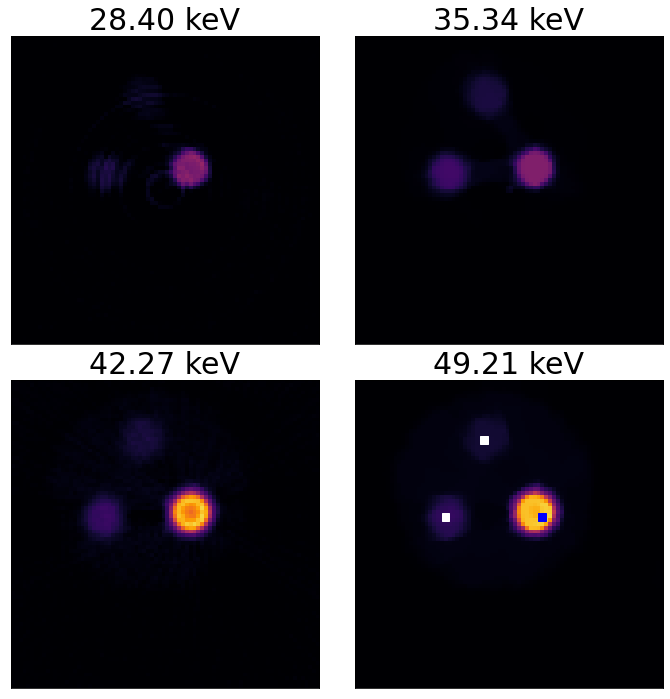

In [4]:
from mpl_toolkits.axes_grid1 import AxesGrid


recons = [powder_fdk_180_180_recon.as_array()[0,40,:,:], 
          powder_tv_tgv_recon.as_array()[25,40,:,:],
          powder_fdk_180_180_recon.as_array()[50,40,:,:], 
          powder_tv_tgv_recon.as_array()[75,40,:,:]]

labels_text = ['{:.2f} keV'.format(ekeV_crop[0]), '{:.2f} keV'.format(ekeV_crop[25]),
               '{:.2f} keV'.format(ekeV_crop[50]), '{:.2f} keV'.format(ekeV_crop[75])]

# set fontsize xticks/yticks
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(12, 12))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.5)

k = 0

for ax in grid:
    im = ax.imshow(recons[k], cmap="inferno", vmin = 0.0, vmax = 0.03)   
    
    if k==0:
        ax.set_title(labels_text[0],fontsize=30)
    if k==1:
        ax.set_title(labels_text[1],fontsize=30)  
    if k==2:
        ax.set_title(labels_text[2],fontsize=30)  
    if k==3:
        ax.set_title(labels_text[3],fontsize=30)  
        rect1 = patches.Rectangle((47,34),2,2,linewidth=1,edgecolor='b',facecolor='b')
        ax.add_patch(rect1)
        rect2 = patches.Rectangle((22,34),2,2,linewidth=1,edgecolor='w',facecolor='w')
        ax.add_patch(rect2)
        rect3 = patches.Rectangle((32,14),2,2,linewidth=1,edgecolor='w',facecolor='w')
        ax.add_patch(rect3)
            
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

cbar = grid.cbar_axes[0].colorbar(im,ticks=[0.0,0.005,0.010,0.015,0.020,0.025,0.030])

### Figure 1c

Spectral plot for one powder phase 1, showing the presence of the cerium absorption edge

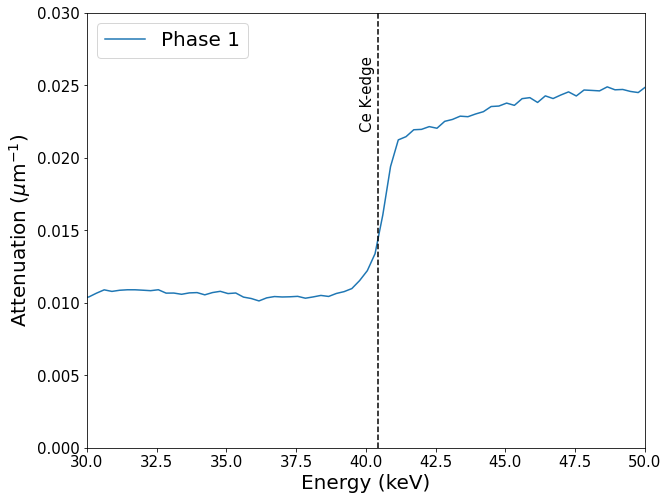

In [5]:
# Average over the ROI
avg_y_x = powder_fdk_180_180_recon.as_array()[:,40,34:36,47:49]
avg_ROI = np.mean(np.mean(avg_y_x,axis=1),axis=1)

# Plot result
plt.figure(figsize=(10,8))
plt.plot(ekeV_crop,avg_ROI,label='Phase 1',linestyle='-')#,plt.xscale('log')

plt.axvline(x=40.443, color = 'black', linestyle = "--")
plt.text(39.8, 0.022, "Ce K-edge", rotation=90, fontsize=15, color = "black")
plt.ylim(0.0,0.03),plt.xlim(30.0,50.0)
plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.legend(fontsize=20, loc='upper left')

### Figure 1d

Measured vs. Theoretical plots for powder phases 2 and 3, comparing the attenuation values and slopes as a function of energy.

In [6]:
# Access NIST attenuation data
data_ce = np.array(fetch_coefficients(58)) # cesium
data_fe = np.array(fetch_coefficients(26)) # iron
data_zn = np.array(fetch_coefficients(30)) # zinc
data_al = np.array(fetch_coefficients(13)) # aluminium
data_ox = np.array(fetch_coefficients(8)) # oxygen

# Convert MeV to keV
data_ce[:,[0]] = data_ce[:,[0]]*1000
data_fe[:,[0]] = data_fe[:,[0]]*1000
data_zn[:,[0]] = data_zn[:,[0]]*1000
data_al[:,[0]] = data_al[:,[0]]*1000
data_ox[:,[0]] = data_ox[:,[0]]*1000

# Convert mass attenuation to linear attenuation
rho_ce = 6.76
rho_fe = 7.874
rho_zn = 7.133
rho_al = 2.7
rho_ox = 1.141

# Multiply by density, then scale down to microns
mu_ce = (data_ce[:,[1]] * rho_ce)/10000
mu_fe = (data_fe[:,[1]] * rho_fe)/10000
mu_zn = (data_zn[:,[1]] * rho_zn)/10000
mu_al = (data_al[:,[1]] * rho_al)/10000
mu_ox = (data_ox[:,[1]] * rho_ox)/10000

# Combine Zinc and Oxygen values to get best approximation for ZnO
mu_zn[22:26] = mu_zn[22:26] + mu_ox[11:15]

data_fe[:,[1]] = mu_fe
data_zn[:,[1]] = mu_zn
data_al[:,[1]] = mu_al

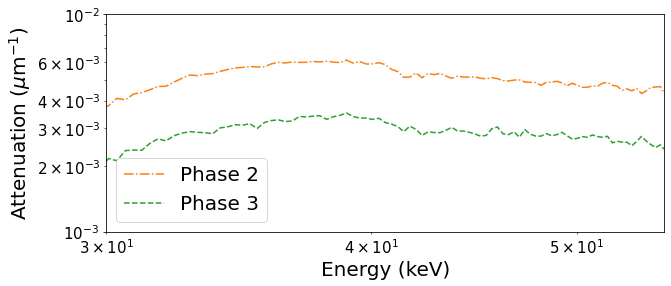

In [7]:
# Plot measured data

# Spectral plot FDK phases - ROIs
avg_y_x_2 = powder_fdk_180_180_recon.as_array()[:,40,34:36,22:24]
avg_ROI_2 = np.mean(np.mean(avg_y_x_2,axis=1),axis=1)
avg_y_x_3 = powder_fdk_180_180_recon.as_array()[:,40,14:16,32:34]
avg_ROI_3 = np.mean(np.mean(avg_y_x_3,axis=1),axis=1)

plt.figure(figsize=(10,4))
plt.loglog(ekeV_crop,avg_ROI_2,label='Phase 2',color='C1',linestyle='-.')
plt.loglog(ekeV_crop,avg_ROI_3,label='Phase 3',color='C2',linestyle='--')

plt.ylim(0.001,0.01)
plt.xlim(30.0,55.0)
plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.legend(fontsize=20, loc='lower left')

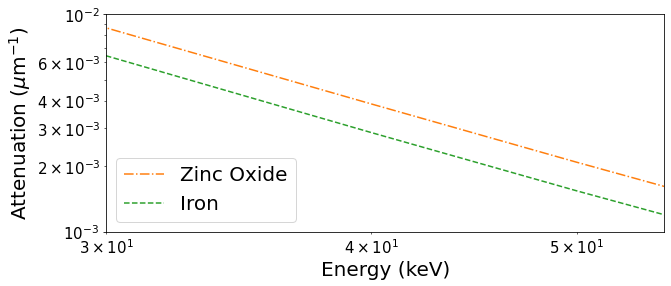

In [8]:
# Plot theoretical data

plt.figure(figsize=(10,4))
plt.loglog(data_zn[:,[0]],data_zn[:,[1]],label="Zinc Oxide",color='C1',linestyle='-.')
plt.loglog(data_fe[:,[0]],data_fe[:,[1]],label="Iron",color='C2',linestyle='--')

plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.ylim(0.001,0.01)
plt.xlim(30.0,55.0)
plt.legend(fontsize=20, loc='lower left')

## Figure 2

Comparison of reconstruction algorithms through inspection of single energy reconstructed slices, spatial and spectral plots.

### Figure 2a

Sets of reconstructed slices for a single energy, directly showing the difference in reconstruction quality between FDK and TV-TGV methods for Scan A and Scan B datasets.

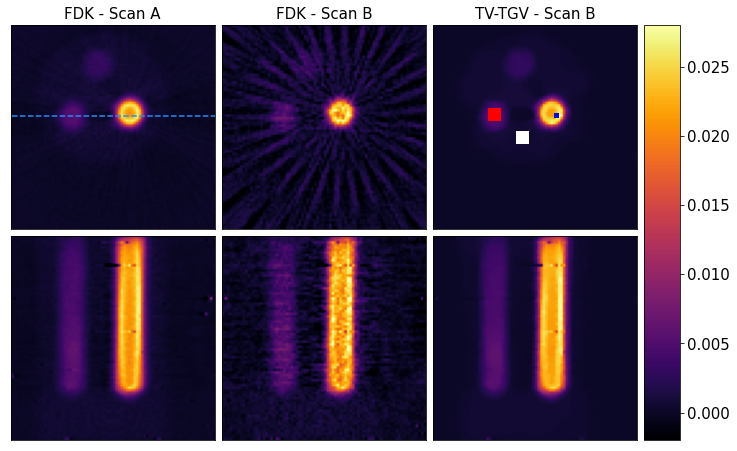

In [9]:
from mpl_toolkits.axes_grid1 import AxesGrid


recons = [powder_fdk_180_180_recon.as_array()[50,40,:,:], 
          powder_fdk_30_30_recon.as_array()[50,40,:,:],
          powder_tv_tgv_recon.as_array()[50,40,:,:],
          powder_fdk_180_180_recon.as_array()[50,:,34,:],
          powder_fdk_30_30_recon.as_array()[50,:,34,:], 
          powder_tv_tgv_recon.as_array()[50,:,34,:]]

labels_text = ['FDK - Scan A',
               'FDK - Scan B',
               'TV-TGV - Scan B']

# set fontsize xticks/yticks
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(12, 8))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 3),
                axes_pad=0.1,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1)

k = 0

for ax in grid:
    im = ax.imshow(recons[k], cmap="inferno",vmin = -0.002, vmax = 0.028)   
    
    if k==0:
        ax.set_title(labels_text[0],fontsize=15)
        ax.hlines(y=35,xmin=0,xmax=80,color='dodgerblue',linestyle='--')
    if k==1:
        ax.set_title(labels_text[1],fontsize=15)  
    if k==2:
        ax.set_title(labels_text[2],fontsize=15)  
        rect3 = patches.Rectangle((47,34),2,2,linewidth=1,facecolor='b')
        ax.add_patch(rect3)
        rect1 = patches.Rectangle((21,32),5,5,linewidth=1,facecolor='r')
        ax.add_patch(rect1)
        rect2 = patches.Rectangle((32,41),5,5,linewidth=1,facecolor='w')
        ax.add_patch(rect2)
        
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

cbar = grid.cbar_axes[0].colorbar(im,ticks=[0.0,0.005,0.01,0.015,0.02,0.025])

### Figure 2b

Comparison of reconstruction quality through measurement of spatial linear profile plots.

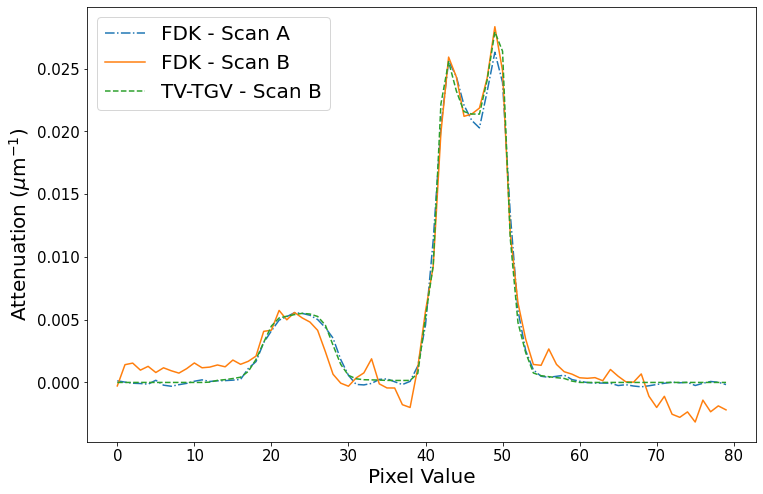

In [10]:
plt.figure(figsize=(12,8))
plt.plot(powder_fdk_180_180_recon.as_array()[49,40,35,:],label='FDK - Scan A',linestyle='-.')
plt.plot(powder_fdk_30_30_recon.as_array()[49,40,35,:],label='FDK - Scan B',linestyle='-')
plt.plot(powder_tv_tgv_recon.as_array()[49,40,35,:],label='TV-TGV - Scan B',linestyle='--')

plt.xlabel('Pixel Value',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.legend(fontsize=20, loc='upper left')

### Figure 2c

Comparison of reconstruction quality through measurement of spectral profile plots in powder phase 1, showing the cerium absorption edge.

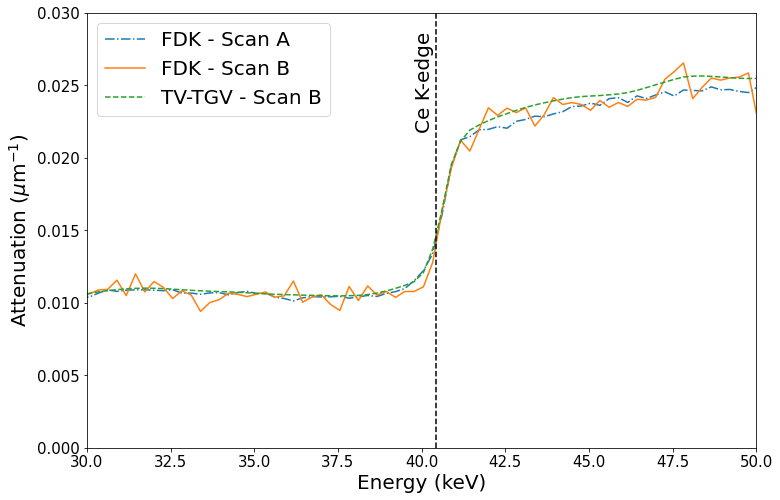

In [11]:
avg_y_x_180 = powder_fdk_180_180_recon.as_array()[:,40,34:36,47:49]
avg_ROI_180 = np.mean(np.mean(avg_y_x_180,axis=1),axis=1)
avg_y_x_30 = powder_fdk_30_30_recon.as_array()[:,40,34:36,47:49]
avg_ROI_30 = np.mean(np.mean(avg_y_x_30,axis=1),axis=1)
avg_y_x_TGV = powder_tv_tgv_recon.as_array()[:,40,34:36,47:49]
avg_ROI_TGV = np.mean(np.mean(avg_y_x_TGV,axis=1),axis=1)
    
plt.figure(figsize=(12,8))
plt.plot(ekeV_crop,avg_ROI_180,label='FDK - Scan A',linestyle='-.')
plt.plot(ekeV_crop,avg_ROI_30,label='FDK - Scan B',linestyle='-')
plt.plot(ekeV_crop,avg_ROI_TGV,label='TV-TGV - Scan B',linestyle='--')

plt.axvline(x=40.443, color = 'black', linestyle = "--")
plt.text(39.8, 0.022, "Ce K-edge", rotation=90, fontsize=20, color = "black")
plt.ylim(0.0,0.03),plt.xlim(30.0,50.0)
plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.legend(fontsize=20, loc='upper left')

## Figure 3

Quantitative evaluation of reconstruction quality for Scan B datasets, relative to the 'ground truth', optimum state of Scan A FDK.

### Figure 3a

Channelwise CNR calculations, between ROIs selected in the ZnO (powder phase 2) and Al (background phase). Calculations were made on a single image slice in the transverse plane.  
For this we need the mean and standard devaition values for the two ROIs (ZnO and Al). This must be caluclated for all three reconstructions.

In [12]:
# Values for ZnO phase
# Scan A FDK values
avg_y_x_180FDK_zn = powder_fdk_180_180_recon.as_array()[:,40,32:37,21:26]
avg_ROI_180FDK_zn = np.mean(np.mean(avg_y_x_180FDK_zn,axis=1),axis=1)
std_ROI_180FDK_zn = np.std(np.std(avg_y_x_180FDK_zn,axis=1),axis=1)
mean_val_180FDK_zn = np.mean(std_ROI_180FDK_zn)
std_ROI_180FDK_zn = np.ones(100)*mean_val_180FDK_zn

# Scan B FDK values
avg_y_x_30FDK_zn = powder_fdk_30_30_recon.as_array()[:,40,32:37,21:26]
avg_ROI_30FDK_zn = np.mean(np.mean(avg_y_x_30FDK_zn,axis=1),axis=1)
std_ROI_30FDK_zn = np.std(np.std(avg_y_x_30FDK_zn,axis=1),axis=1)
mean_val_30FDK_zn = np.mean(std_ROI_30FDK_zn)
std_ROI_30FDK_zn = np.ones(100)*mean_val_30FDK_zn

# Scan B TV-TGV values
avg_y_x_TGV_zn = powder_tv_tgv_recon.as_array()[:,40,32:37,21:26]
avg_ROI_TGV_zn = np.mean(np.mean(avg_y_x_TGV_zn,axis=1),axis=1)
std_ROI_TGV_zn = np.std(np.std(avg_y_x_TGV_zn,axis=1),axis=1)
mean_val_TGV_zn = np.mean(std_ROI_TGV_zn)
std_ROI_TGV_zn = np.ones(100)*mean_val_TGV_zn

# Values for Al phase (background)
# Scan A FDK values
avg_y_x_180FDK_bg_al = powder_fdk_180_180_recon.as_array()[:,40,41:46,32:37]
avg_ROI_180FDK_bg_al = np.mean(np.mean(avg_y_x_180FDK_bg_al,axis=1),axis=1)
std_ROI_180FDK_bg_al = np.std(np.std(avg_y_x_180FDK_bg_al,axis=1),axis=1)
mean_val_180FDK_bg_al = np.mean(std_ROI_180FDK_bg_al)
std_ROI_180FDK_bg_al = np.ones(100)*mean_val_180FDK_bg_al

# Scan B FDK values
avg_y_x_30FDK_bg_al = powder_fdk_30_30_recon.as_array()[:,40,41:46,32:37]
avg_ROI_30FDK_bg_al = np.mean(np.mean(avg_y_x_30FDK_bg_al,axis=1),axis=1)
std_ROI_30FDK_bg_al = np.std(np.std(avg_y_x_30FDK_bg_al,axis=1),axis=1)
mean_val_30FDK_bg_al = np.mean(std_ROI_30FDK_bg_al)
std_ROI_30FDK_bg_al = np.ones(100)*mean_val_30FDK_bg_al

# Scan B TV-TGV values
avg_y_x_TGV_bg_al = powder_tv_tgv_recon.as_array()[:,40,41:46,32:37]
avg_ROI_TGV_bg_al = np.mean(np.mean(avg_y_x_TGV_bg_al,axis=1),axis=1)
std_ROI_TGV_bg_al = np.std(np.std(avg_y_x_TGV_bg_al,axis=1),axis=1)
mean_val_TGV_bg_al = np.mean(std_ROI_TGV_bg_al)
std_ROI_TGV_bg_al = np.ones(100)*mean_val_TGV_bg_al

In [13]:
# Calculate CNR values using cnr_spatial function
cnr_180FDK = cnr_spatial(avg_ROI_180FDK_zn,std_ROI_180FDK_zn,avg_ROI_180FDK_bg_al,std_ROI_180FDK_bg_al)
cnr_30FDK = cnr_spatial(avg_ROI_30FDK_zn,std_ROI_30FDK_zn,avg_ROI_30FDK_bg_al,std_ROI_30FDK_bg_al)
cnr_TGV = cnr_spatial(avg_ROI_TGV_zn,std_ROI_TGV_zn,avg_ROI_TGV_bg_al,std_ROI_TGV_bg_al)

Calculation Complete!
Calculation Complete!
Calculation Complete!


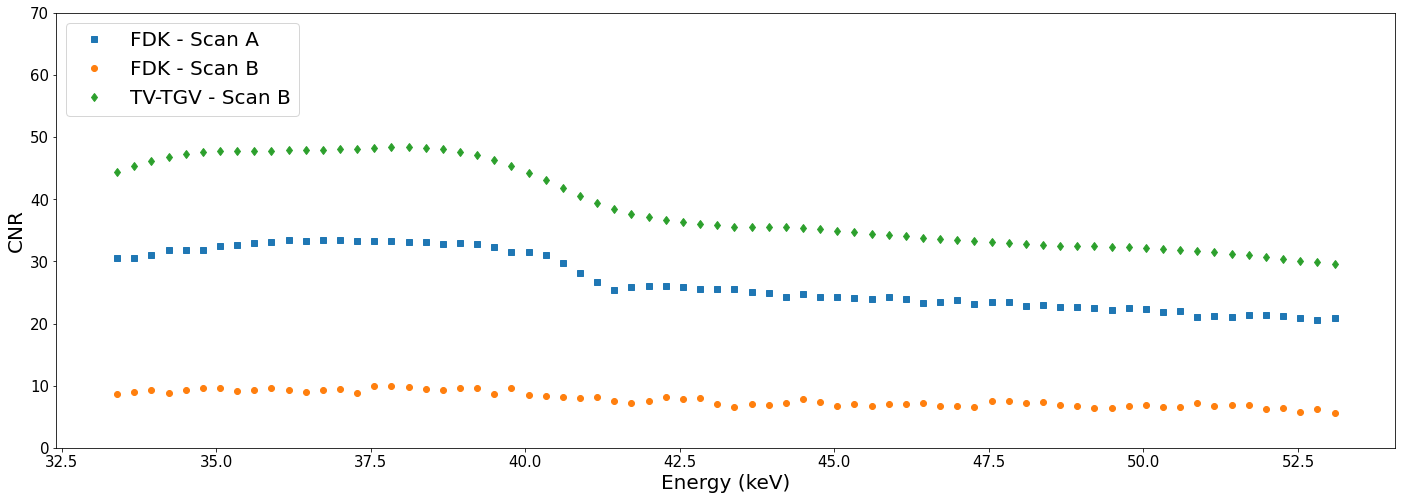

In [14]:
# Plot results for each reconstructed dataset

plt.figure(figsize=(24,8))
plt.plot(ekeV_crop[18:90],cnr_180FDK[18:90],'s',markersize=6,label = 'FDK - Scan A')
plt.plot(ekeV_crop[18:90],cnr_30FDK[18:90],'o',markersize=6,label = 'FDK - Scan B')
plt.plot(ekeV_crop[18:90],cnr_TGV[18:90],'d',markersize=6,label = 'TV-TGV - Scan B')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Energy (keV)',fontsize=20)
plt.ylabel('CNR',fontsize=20)
plt.ylim((0,70))
plt.legend(fontsize=20, loc='upper left')

### Figure 3b

Channelwise RMSE values calculated using ROI 1 within the cerium phase. Values calculated for all channels through comparison between Scan A and each respective Scan B reconstruction.  
We start by calculating the mean and standard deviation values for the cerium powder phase ROI.

In [15]:
#%% Calculate ROIs for single channel analysis

# Scan A FDK values
avg_y_x_180FDK_ce = powder_fdk_180_180_recon.as_array()[:,40,32:34,21:23]
avg_ROI_180FDK_ce = np.mean(np.mean(avg_y_x_180FDK_ce,axis=1),axis=1)
std_ROI_180FDK_ce = np.std(np.std(avg_y_x_180FDK_ce,axis=1),axis=1)

# Scan B FDK values
avg_y_x_30FDK_ce = powder_fdk_30_30_recon.as_array()[:,40,32:34,21:23]
avg_ROI_30FDK_ce = np.mean(np.mean(avg_y_x_30FDK_ce,axis=1),axis=1)
std_ROI_30FDK_ce = np.std(np.std(avg_y_x_30FDK_ce,axis=1),axis=1)

# Scan B TV-TGV values
avg_y_x_TGV_ce = powder_tv_tgv_recon.as_array()[:,40,32:34,21:23]
avg_ROI_TGV_ce = np.mean(np.mean(avg_y_x_TGV_ce,axis=1),axis=1)
std_ROI_TGV_ce = np.std(np.std(avg_y_x_TGV_ce,axis=1),axis=1)

In [16]:
# Calculate channelwise RMSE over the ROI, for each of the Scan B results relative to Scan A
RMSE_ScanB_FDK  = np.zeros(powder_tv_tgv_recon.shape[0])
RMSE_ScanB_TGV  = np.zeros(powder_tv_tgv_recon.shape[0])
RMSE_ScanB_FDK  = rmse_sing_chan(avg_ROI_30FDK_ce,avg_ROI_180FDK_ce,RMSE_ScanB_FDK)
RMSE_ScanB_TGV  = rmse_sing_chan(avg_ROI_TGV_ce,avg_ROI_180FDK_ce,RMSE_ScanB_TGV)

Calculation Complete!
Calculation Complete!


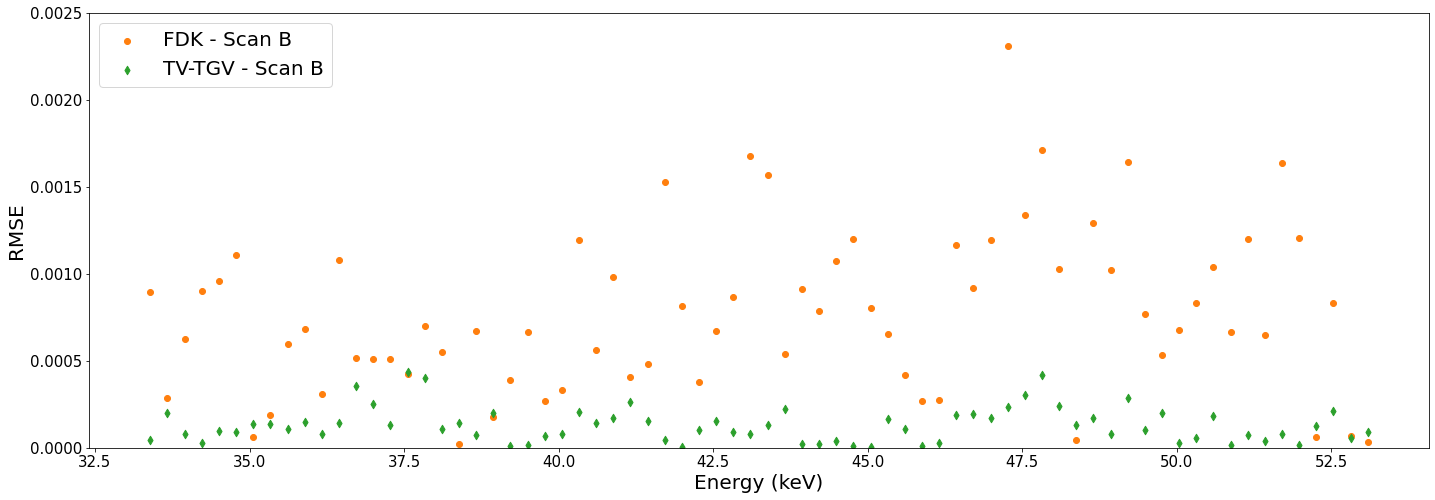

In [17]:
# Plot results

plt.figure(figsize=(24,8))
plt.scatter(ekeV_crop[18:90],RMSE_ScanB_FDK[18:90],label='FDK - Scan B',marker='o',color='C1')
plt.scatter(ekeV_crop[18:90],RMSE_ScanB_TGV[18:90],label='TV-TGV - Scan B',marker='d',color='C2')
plt.ylim([0.0,0.0025])
plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('RMSE',fontsize=20)
plt.legend(fontsize=20,loc='upper left')